## Bring in libraries and dataframes and set indexes

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates

In [104]:
ObsData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
ObsData.columns = ObsData.columns.droplevel([3,4,5,6,7,8,10])

Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
Nitrogens = ObsData.columns.get_level_values(1).drop_duplicates().values
Irrigations = ObsData.columns.get_level_values(2).drop_duplicates().values
Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values

lines = ['--','-']
gaps = [3,0.000001]
colors = ['orange','purple','green']
alphas = [0.33,0.66,1]

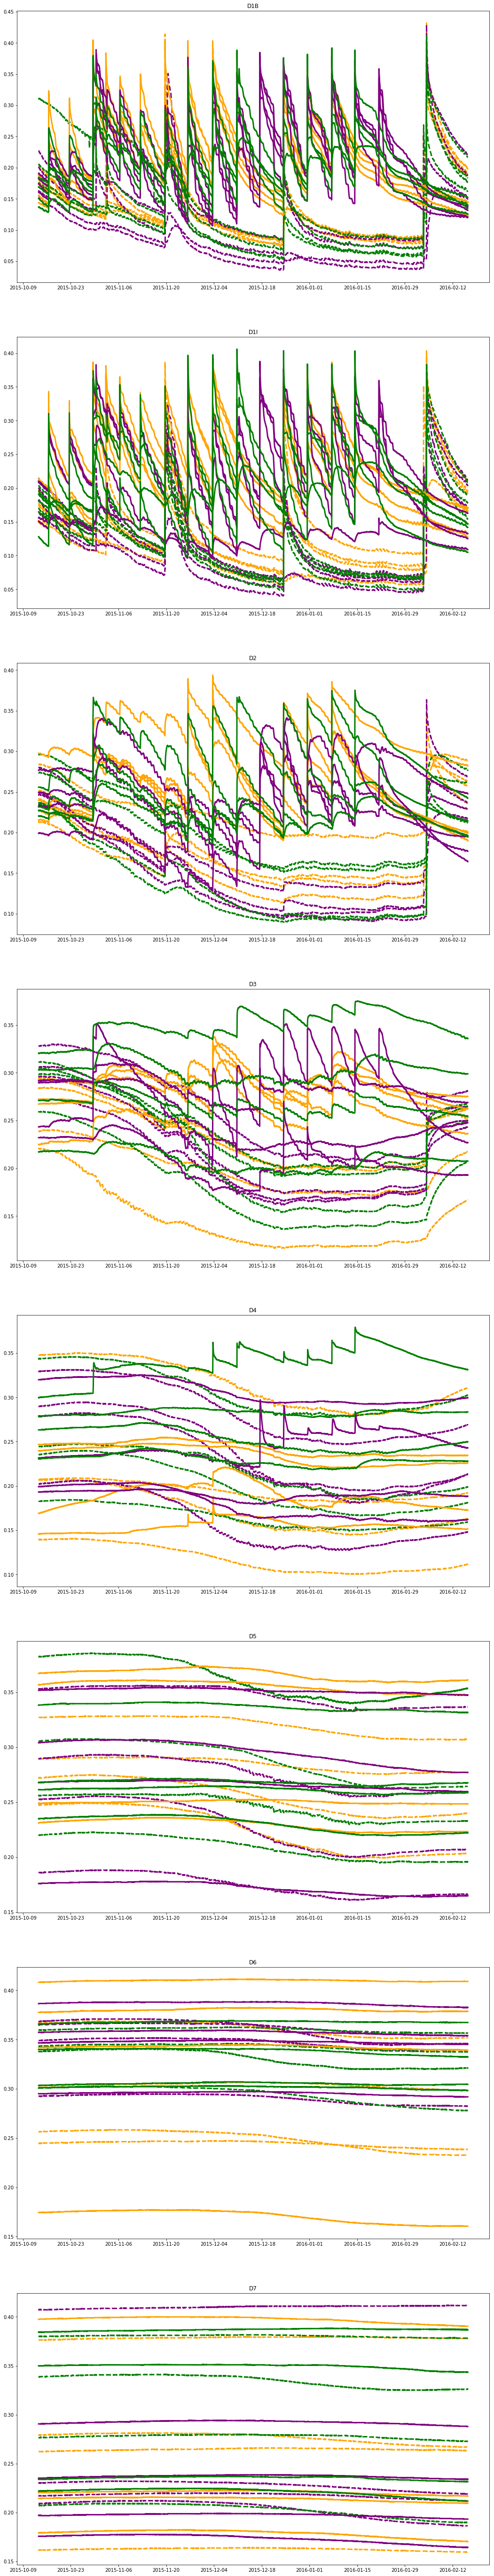

In [105]:
Graph = plt.figure(figsize=(18,100))
pos = 1
for D in Depths:
    Graph.add_subplot(8,1,pos)
    Ipos = 0
    for I in Irrigations:
        Npos = 0
        for N in Nitrogens:
            plt.plot(ObsData.loc[:,(D,N,I)],lines[Ipos],lw=3,color=colors[Npos])
            plt.title(D)
            Npos += 1
        Ipos+= 1
    pos +=1

## There is a problem with one sensor in the top layer

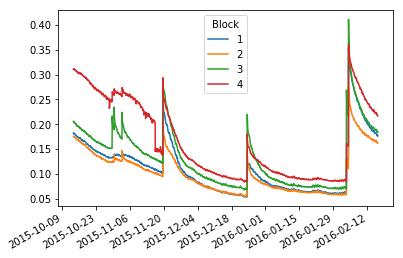

In [103]:
ObsData.loc[:,('D1B','50','Dryland')].plot()

## Block 4 for 50kg Dryland
Set the dodgy data to nan

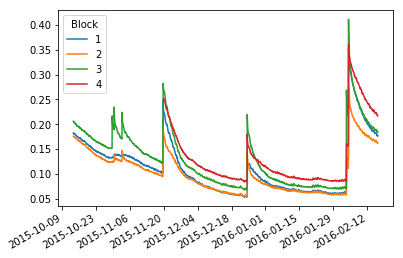

In [115]:
ObsData.loc[:,('D1B','50','Dryland')].plot()

In [114]:
ObsData.loc[:'2015-11-19',('D1B','50','Dryland','4')] = np.nan

## Calculate soil water deficit

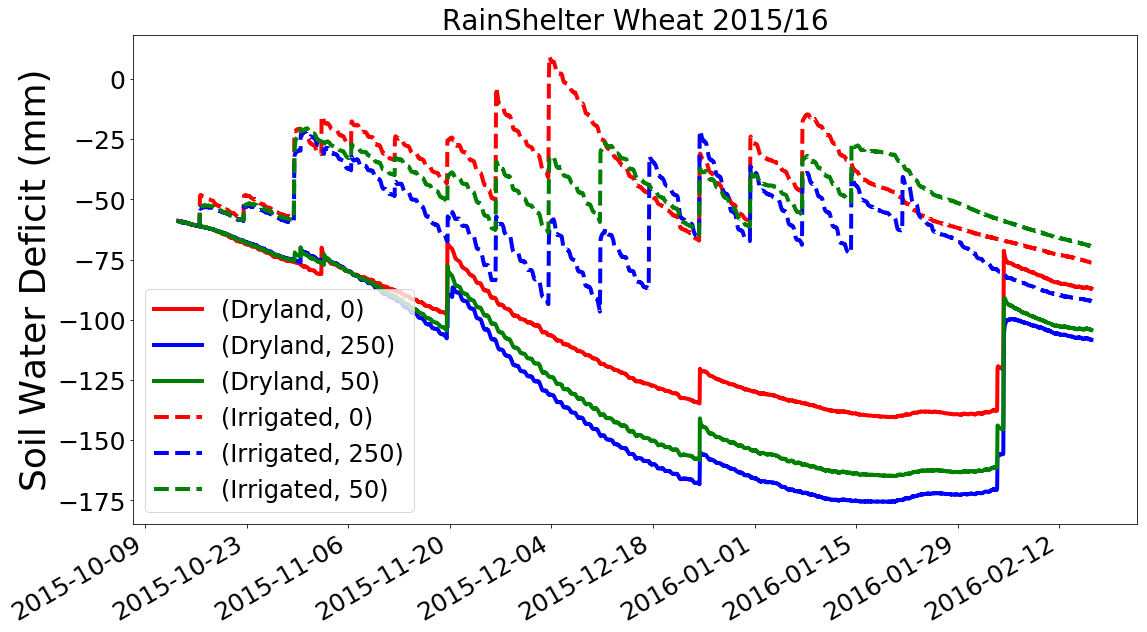

In [120]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  ObsData.groupby(level=['Depth','Irrigation', 'Nitrogen'],axis=1).mean()
#DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
               DataMeans.loc[:,'D1B'] * 150/2 + \
               DataMeans.loc[:,'D2'] * 150 + \
               DataMeans.loc[:,'D3'] * 300 + \
               DataMeans.loc[:,'D4'] * 300 + \
               DataMeans.loc[:,'D5'] * 300 + \
               DataMeans.loc[:,'D6'] * 300 + \
               DataMeans.loc[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2015-10-15'] + 60  # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series
SoilWaterDeficit.plot(figsize=(18,10),style=['r-','b-','g-','r--','b--','g--'], linewidth=4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)

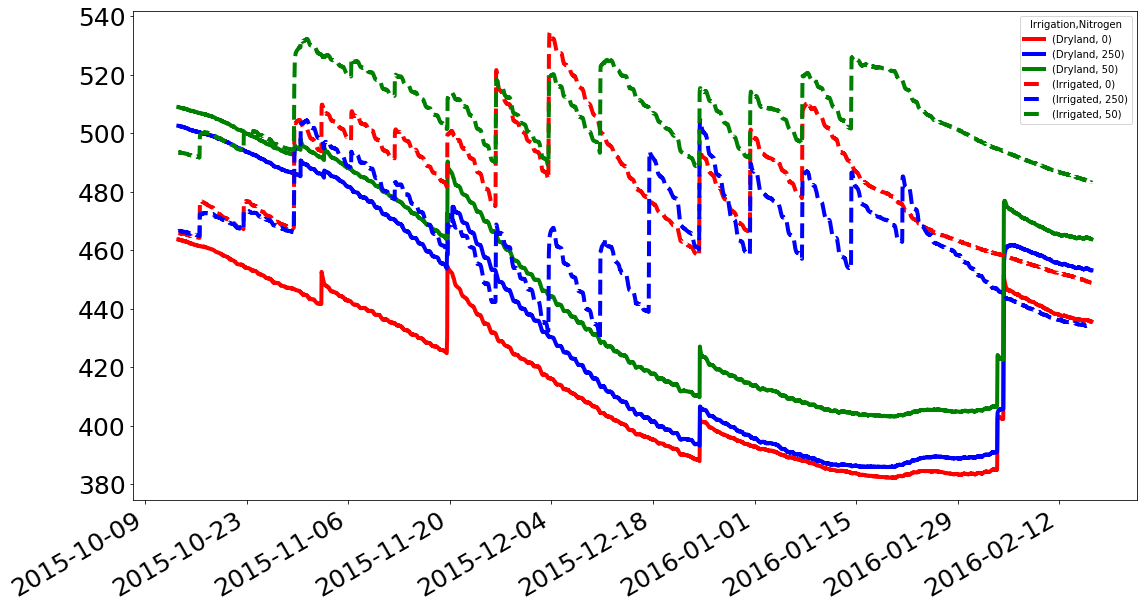

In [118]:
ProfileWater.plot(figsize=(18,10),style=['r-','b-','g-','r--','b--','g--'], linewidth=4)
plt.tick_params(labelsize=25)

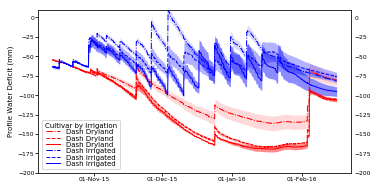

In [125]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Nitrogen','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2015-10-20'] + 60
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2)

#Start = '2011-07-01'
#Depths = ['D7', 'D23', u'D30', 'D50' , 'D70', 'D90','D110', 'D130', 'D150']
Nitrogens = ['0','50','250']
Irrigations = ['Dryland', 'Irrigated']
lines = ['-.','--','-']
gaps = [3,0.000001]
colors = ['r','b']
alphas = [0.15,0.3,0.45]

Graph = plt.figure(figsize=(5.6,3))
fig = Graph.add_subplot(1,1,1)
IrrPos = 0
for Irr in Irrigations:
    NPos = 0
    for N in Nitrogens:
        Ind = SoilWaterDeficit2.loc[:,(Irr,N)].index
        Med = SoilWaterDeficit2.loc[:,(Irr,N)].median(axis=1)
        SEM = SoilWaterDeficit2.loc[:,(Irr,N)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=alphas[NPos],lw=0)
        plt.plot(Ind,Med,lines[NPos],color=colors[IrrPos], linewidth = 1,label = Cul + ' ' + Irr)
        NPos += 1
    IrrPos+=1

    plt.ylabel('Profile Water Deficit (mm)', fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=True,labelsize=6, length = 3, direction = 'out', pad = 1)
        
#     ledg = plt.legend(loc=3,numpoints=1,fontsize = 24,labelspacing = 0.05, 
#                       title='Treatment')
#     ledg.get_title().set_fontsize(28)
#     ledg.get_title().set_weight('bold')
plt.ylim(-200,10)
# plt.xlim('2014-11-01','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(7)
#ledg.get_title().set_weight('bold')
plt.tight_layout
plt.savefig('Fig_1.jpg',dpi=1000)

In [126]:
DeltaWater = ProfileWater2.diff()
DeltaWater.to_pickle('.\DataFrames\ProfileWaterDelta.pkl')
SWD = SoilWaterDeficit.resample('D').mean()
SWD.to_pickle('.\DataFrames\DailySWD.pkl')